In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

print(breast_cancer_wisconsin_diagnostic)

# Data (as pandas dataframes)
x = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

print(x)
print(y)

{'data': {'ids':            ID
0      842302
1      842517
2    84300903
3    84348301
4    84358402
..        ...
564    926424
565    926682
566    926954
567    927241
568     92751

[569 rows x 1 columns], 'features':      radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0      17.99     10.38      122.80  1001.0      0.11840       0.27760   
1      20.57     17.77      132.90  1326.0      0.08474       0.07864   
2      19.69     21.25      130.00  1203.0      0.10960       0.15990   
3      11.42     20.38       77.58   386.1      0.14250       0.28390   
4      20.29     14.34      135.10  1297.0      0.10030       0.13280   
..       ...       ...         ...     ...          ...           ...   
564    21.56     22.39      142.00  1479.0      0.11100       0.11590   
565    20.13     28.25      131.20  1261.0      0.09780       0.10340   
566    16.60     28.08      108.30   858.1      0.08455       0.10230   
567    20.60     29.33      140.10  1265.0      

/tmp/ipykernel_938/2493831312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].map({'M': 1, 'B': 0})


Mean Squared Error Loss on Test Set: 0.018601277843117714


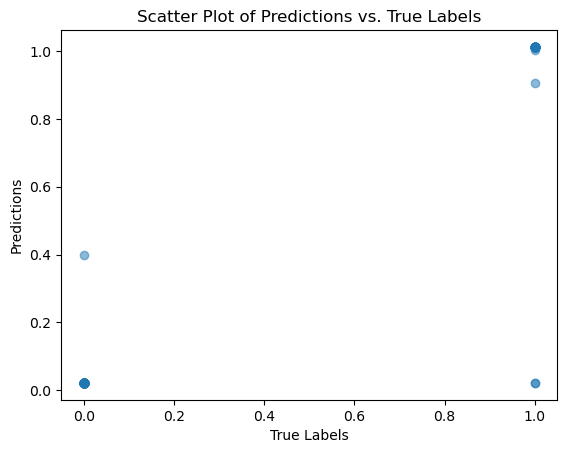

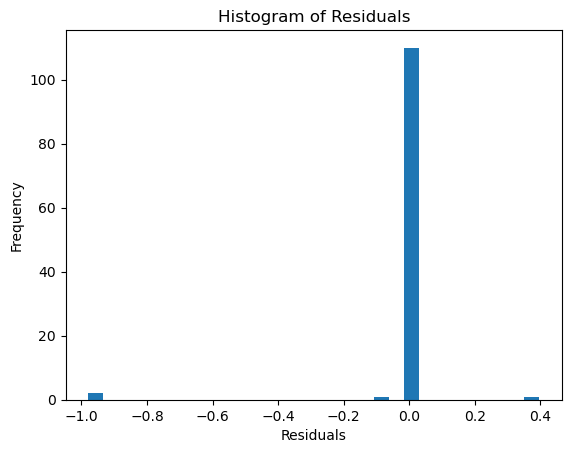

In [80]:

# Assuming 'y' is continuous (regression problem)

# Encode 'Diagnosis' column to numerical values
y['Diagnosis'] = y['Diagnosis'].map({'M': 1, 'B': 0})

# Create a continuous DataFrame
y_continuous = pd.DataFrame(y, columns=['Diagnosis'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_continuous, test_size=0.2)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert data to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train_scaled)
y_train_tensor = torch.FloatTensor(np.array(y_train['Diagnosis']))
x_test_tensor = torch.FloatTensor(x_test_scaled)
y_test_tensor = torch.FloatTensor(np.array(y_test['Diagnosis']))
y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)


# Combine input features and target labels into a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Set random seed for reproducibility
#torch.manual_seed(42)

# Define the neural network model for regression
class RegressionNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RegressionNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Instantiate the regression model
input_size = x_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 128
output_size = 1  # Single output node for regression

regression_model = RegressionNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define loss function and optimizer for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.01)

# Training the regression model
num_epochs = 500
batch_size = 4

for epoch in range(num_epochs):
    regression_model.train()
    for i in range(0, len(x_train_tensor), batch_size):
        inputs = x_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = regression_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation on the test set
regression_model.eval()
with torch.no_grad():
    test_outputs = regression_model(x_test_tensor)
    mse_loss = criterion(test_outputs, y_test_tensor)
    print(f"Mean Squared Error Loss on Test Set: {mse_loss.item()}")



import matplotlib.pyplot as plt

# Convert PyTorch tensors to NumPy arrays
test_outputs_np = test_outputs.numpy()
y_test_np = y_test_tensor.numpy()

plt.scatter(y_test_np, test_outputs_np, alpha=0.5)
plt.xlabel("True Labels")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Predictions vs. True Labels")
plt.show()


residuals = test_outputs - y_test_tensor

plt.hist(residuals.numpy(), bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()
